In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image

In [15]:
data_dir = 'cats_vs_dogs' 

def convert_and_preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.image.convert_image_dtype(image, tf.float32)  
    return image, label

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=128
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=128
)

train_data = train_data.map(convert_and_preprocess)
test_data = test_data.map(convert_and_preprocess)

def build_model(regularization=None, dropout_rate=0.0, data_augmentation=False):
    model = models.Sequential()
    
    if data_augmentation:
        model.add(layers.RandomFlip('horizontal'))
        model.add(layers.RandomRotation(0.1))
        model.add(layers.RandomZoom(0.1))
        
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3),
                            kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularization))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models_info = {
    'L1 Regularization': build_model(regularization=regularizers.l1(0.001)),
    'L2 Regularization': build_model(regularization=regularizers.l2(0.01)),
    'Dropout2': build_model(dropout_rate=0.2),
    'Dropout3': build_model(dropout_rate=0.3),
    'Dropout5': build_model(dropout_rate=0.5),
    'Data Augmentation': build_model(data_augmentation=True)
}

histories = {}
for name, model in models_info.items():
    print(f"\nTraining {name}...")
    history = model.fit(train_data, validation_data=test_data, epochs=10, verbose=1)
    histories[name] = history


Found 1013 files belonging to 2 classes.
Using 811 files for training.
Found 1013 files belonging to 2 classes.
Using 202 files for validation.

Training L1 Regularization...
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4656 - loss: 376.6562 - val_accuracy: 0.5396 - val_loss: 77.6510
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4672 - loss: 73.8791 - val_accuracy: 0.5644 - val_loss: 64.0908
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5332 - loss: 62.9687 - val_accuracy: 0.5198 - val_loss: 58.7446
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5763 - loss: 57.1248 - val_accuracy: 0.4703 - val_loss: 52.7378
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6537 - loss: 51.5798 - val_accuracy: 0.6337 - val_loss: 48.2571
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6600 - loss: 47.2854 - val_accuracy: 0.5396 - val_loss: 44.6405
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7550 -

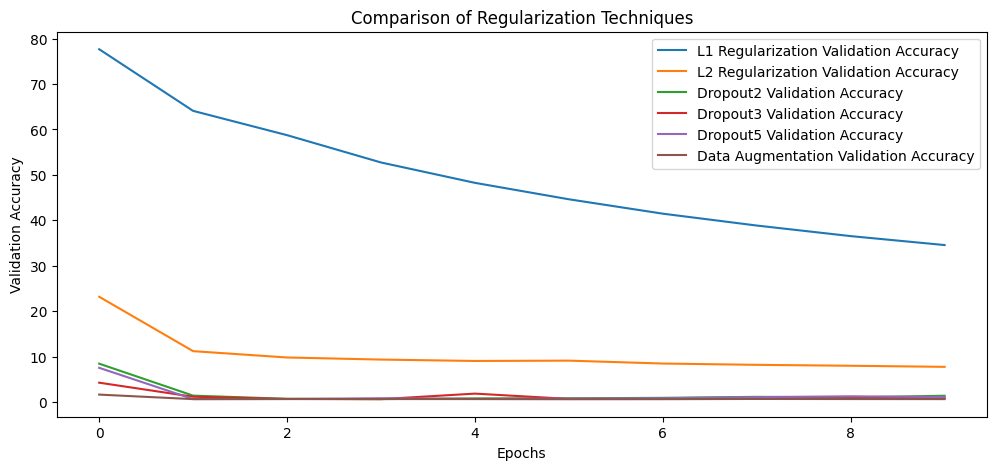

In [16]:
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{name} Validation Accuracy')
plt.title('Comparison of Regularization Techniques')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [11]:
import tensorflow as tf
from visualkeras import layered_view

def visualize_model_structure(model, filename):
    img = layered_view(model, legend=True)
    img.save(filename)
    print(f"Model structure saved as {filename}")

# Visualize all models from models_info
def visualize_all_models(models_info):
    for name, model in models_info.items():
        filename = f"{name.replace(' ', '_')}.png"
        visualize_model_structure(model, filename)

# Example usage
visualize_all_models(models_info)

C:\Users\deepp\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Model structure saved as L1_Regularization.png
Model structure saved as L2_Regularization.png
Model structure saved as Dropout2.png
Model structure saved as Dropout3.png
Model structure saved as Dropout5.png
Model structure saved as Data_Augmentation.png


In [18]:
data_dir = 'cats_vs_dogs' 

def convert_and_preprocess(image, label):
    image = tf.image.resize(image, (256, 256))
    image = tf.image.convert_image_dtype(image, tf.float32)  
    return image, label

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=128
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=128
)

train_data = train_data.map(convert_and_preprocess)
test_data = test_data.map(convert_and_preprocess)

def build_model(regularization=None, dropout_rate=0.0, data_augmentation=False):
    model = models.Sequential()
    
    if data_augmentation:
        model.add(layers.RandomFlip('horizontal'))
        model.add(layers.RandomRotation(0.1))
        model.add(layers.RandomZoom(0.1))
        
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3),
                            kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularization))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularization))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models_info = {
    'L1 Regularization': build_model(regularization=regularizers.l1(0.001)),
    'L2 Regularization': build_model(regularization=regularizers.l2(0.01)),
    'Dropout2': build_model(dropout_rate=0.2),
    'Dropout3': build_model(dropout_rate=0.3),
    'Dropout5': build_model(dropout_rate=0.5),
    'Data Augmentation': build_model(data_augmentation=True)
}

histories = {}
for name, model in models_info.items():
    print(f"\nTraining {name}...")
    history = model.fit(train_data, validation_data=test_data, epochs=10, verbose=1)
    histories[name] = history


Found 1013 files belonging to 2 classes.
Using 811 files for training.
Found 1013 files belonging to 2 classes.
Using 202 files for validation.

Training L1 Regularization...
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - accuracy: 0.4710 - loss: 793.9482 - val_accuracy: 0.5594 - val_loss: 86.7909
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4669 - loss: 80.6823 - val_accuracy: 0.5248 - val_loss: 65.3280
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5608 - loss: 64.7579 - val_accuracy: 0.4455 - val_loss: 61.9449
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5799 - loss: 60.4479 - val_accuracy: 0.5248 - val_loss: 57.0354
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.6498 - loss: 56.2464 - val_accuracy: 0.5891 - val_loss: 53.6642
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6875 - loss: 52.8973 - val_accuracy: 0.4802 - val_loss: 50.8465
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6656 -

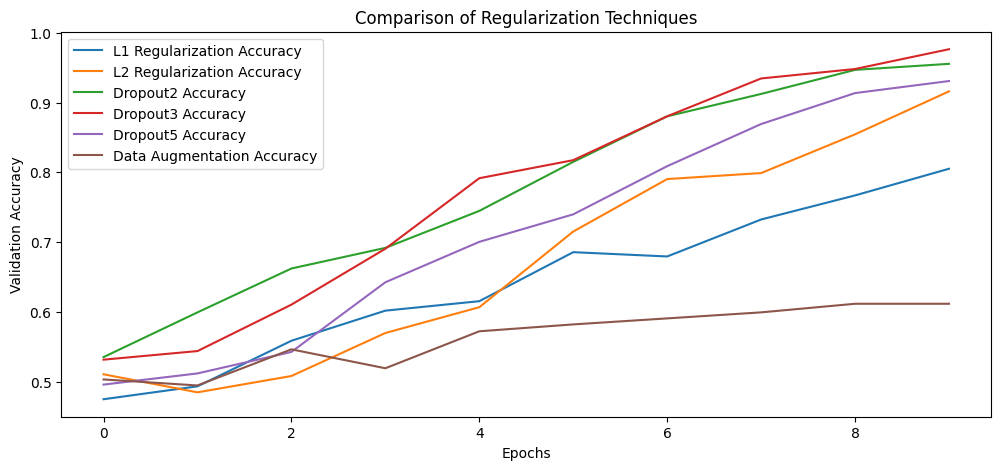

In [24]:
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Accuracy')
plt.title('Comparison of Regularization Techniques')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

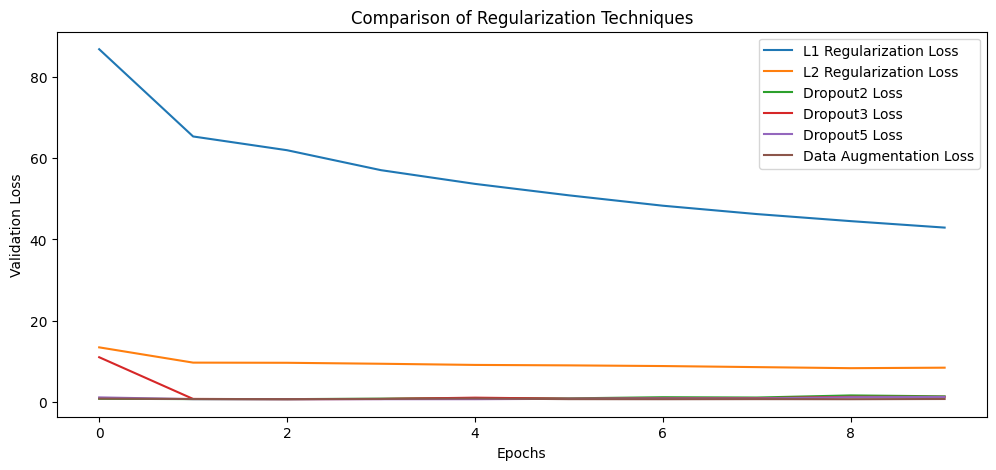

In [27]:
plt.figure(figsize=(12, 5))
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{name} Loss')
plt.title('Comparison of Regularization Techniques')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


Visualizing: L1 Regularization



C:\Users\deepp\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


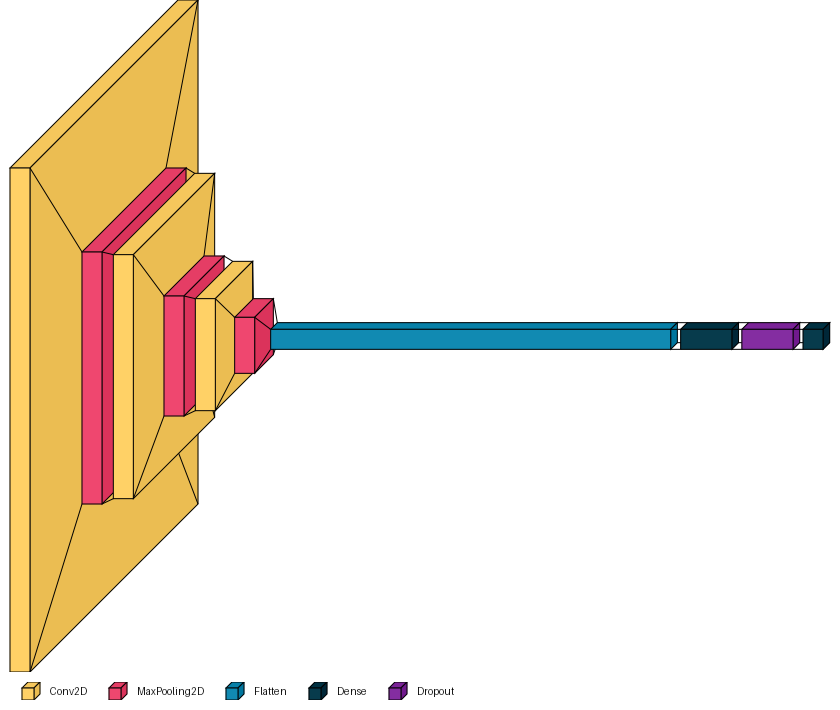


Visualizing: L2 Regularization



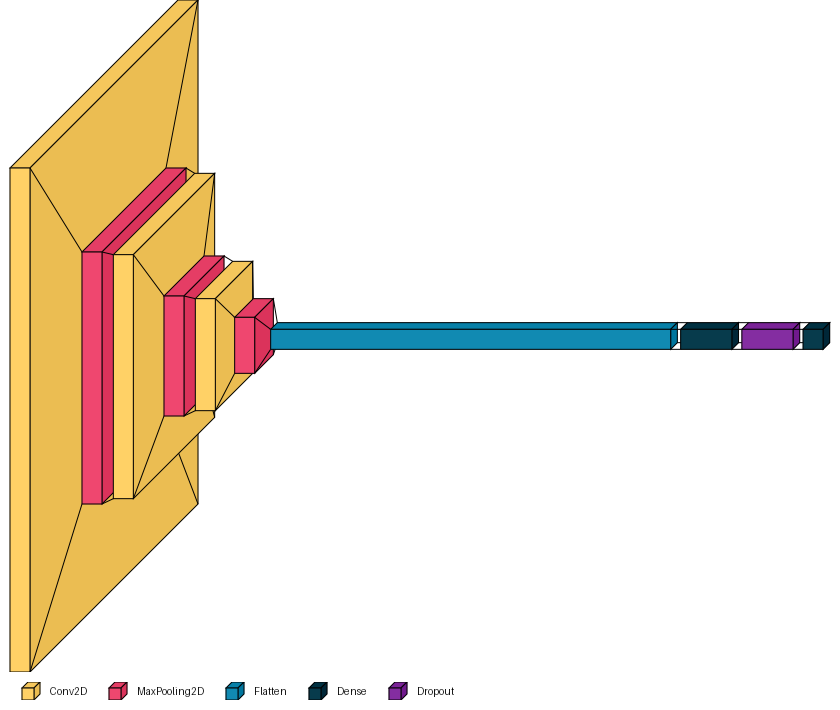


Visualizing: Dropout2



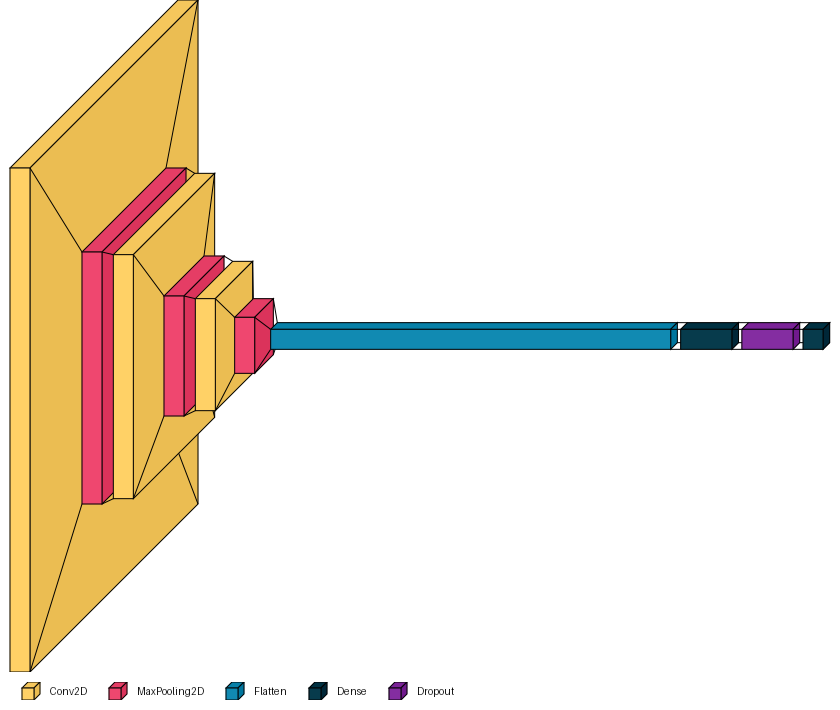


Visualizing: Dropout3



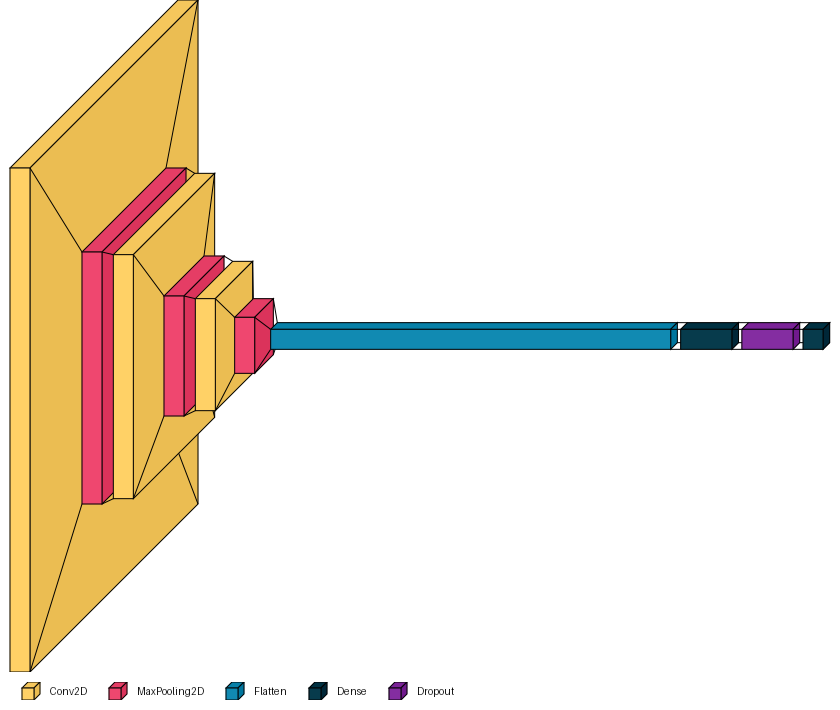


Visualizing: Dropout5



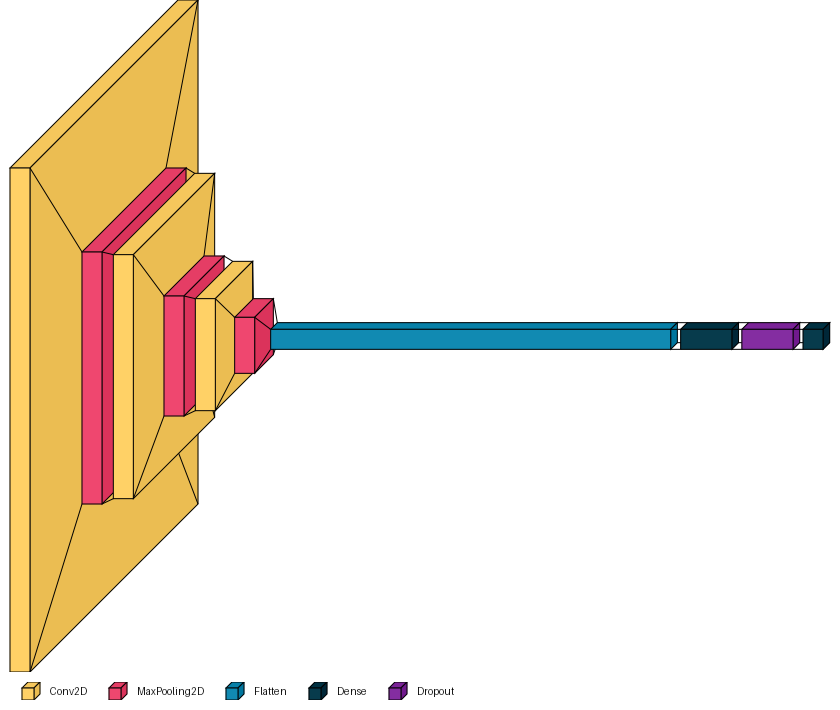


Visualizing: Data Augmentation



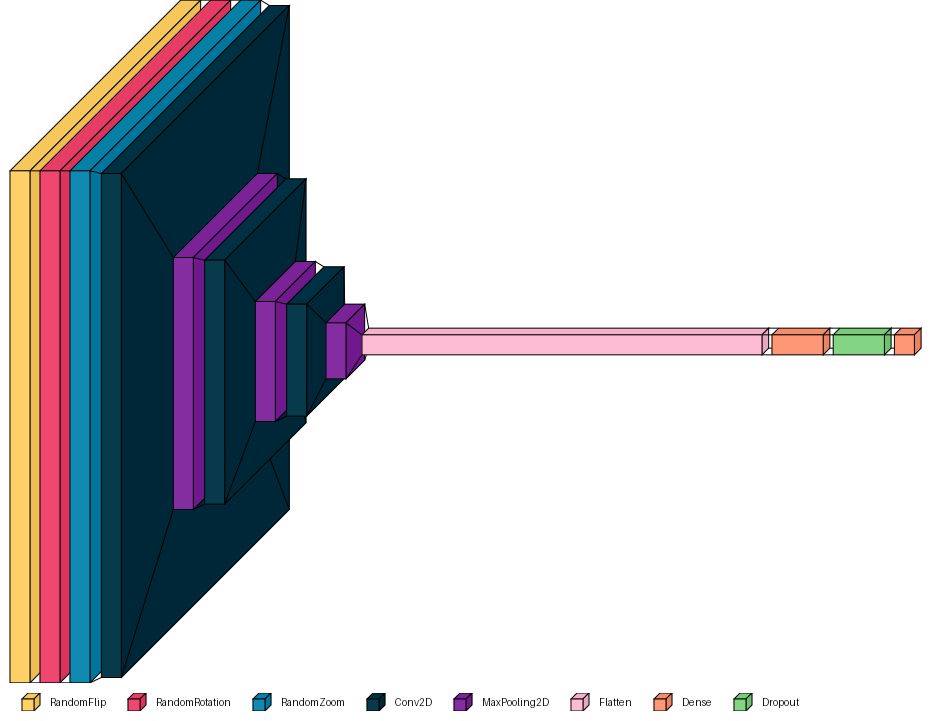

In [13]:
from IPython.display import display
import visualkeras
def visualize_model_structure(model):
    img = visualkeras.layered_view(model, legend=True)
    display(img)

# Visualize all models in notebook
def visualize_all_models(models_info):
    for name, model in models_info.items():
        print(f"\nVisualizing: {name}\n")
        visualize_model_structure(model)

# Example usage
visualize_all_models(models_info)



Visualizing: L1 Regularization



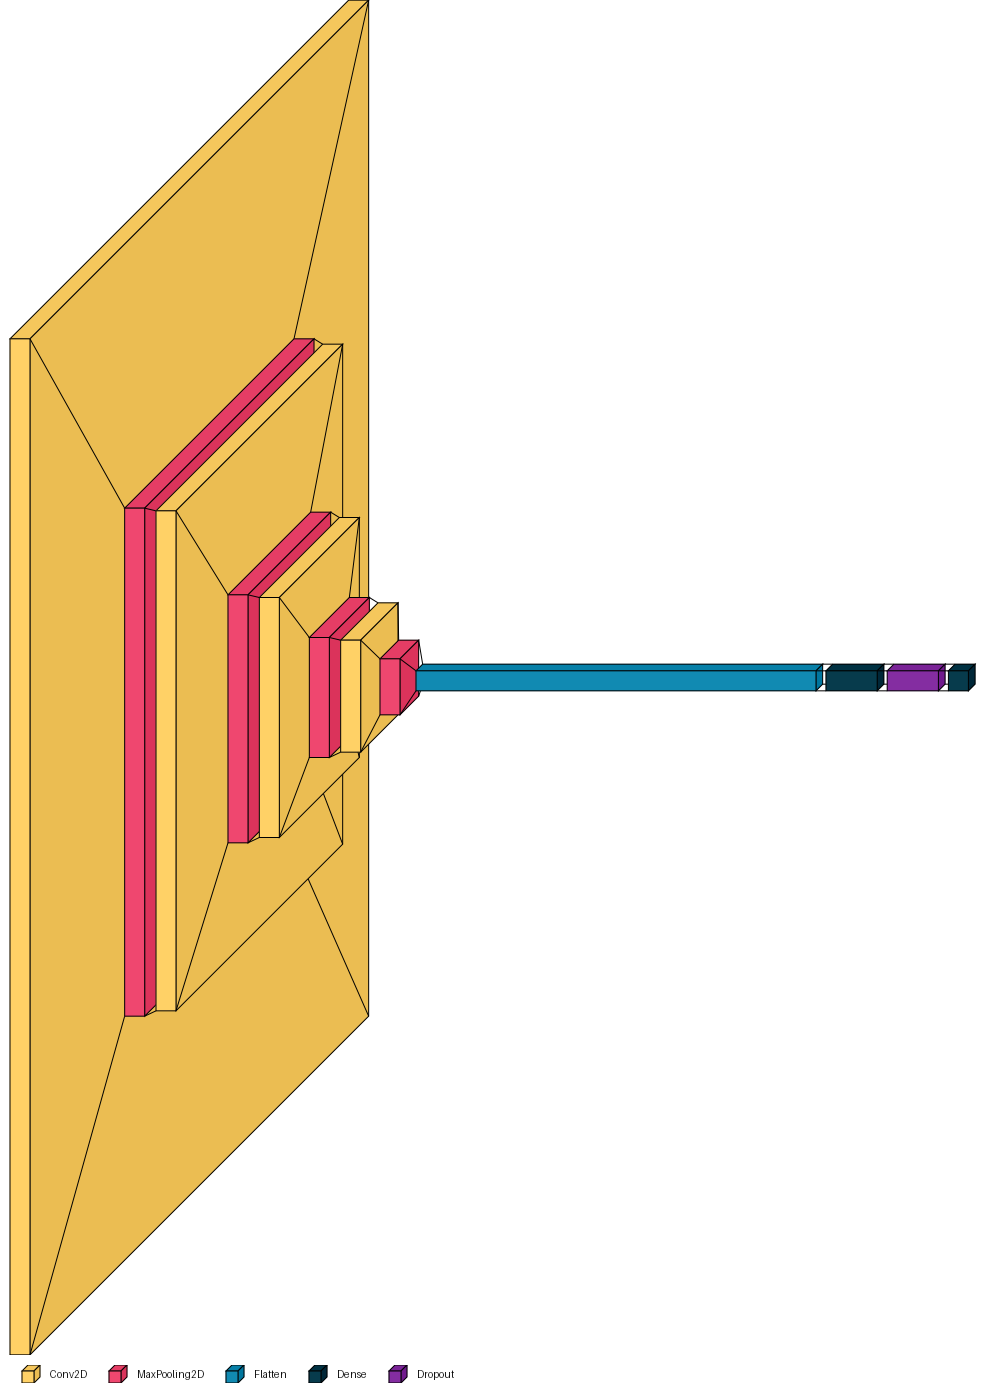


Visualizing: L2 Regularization



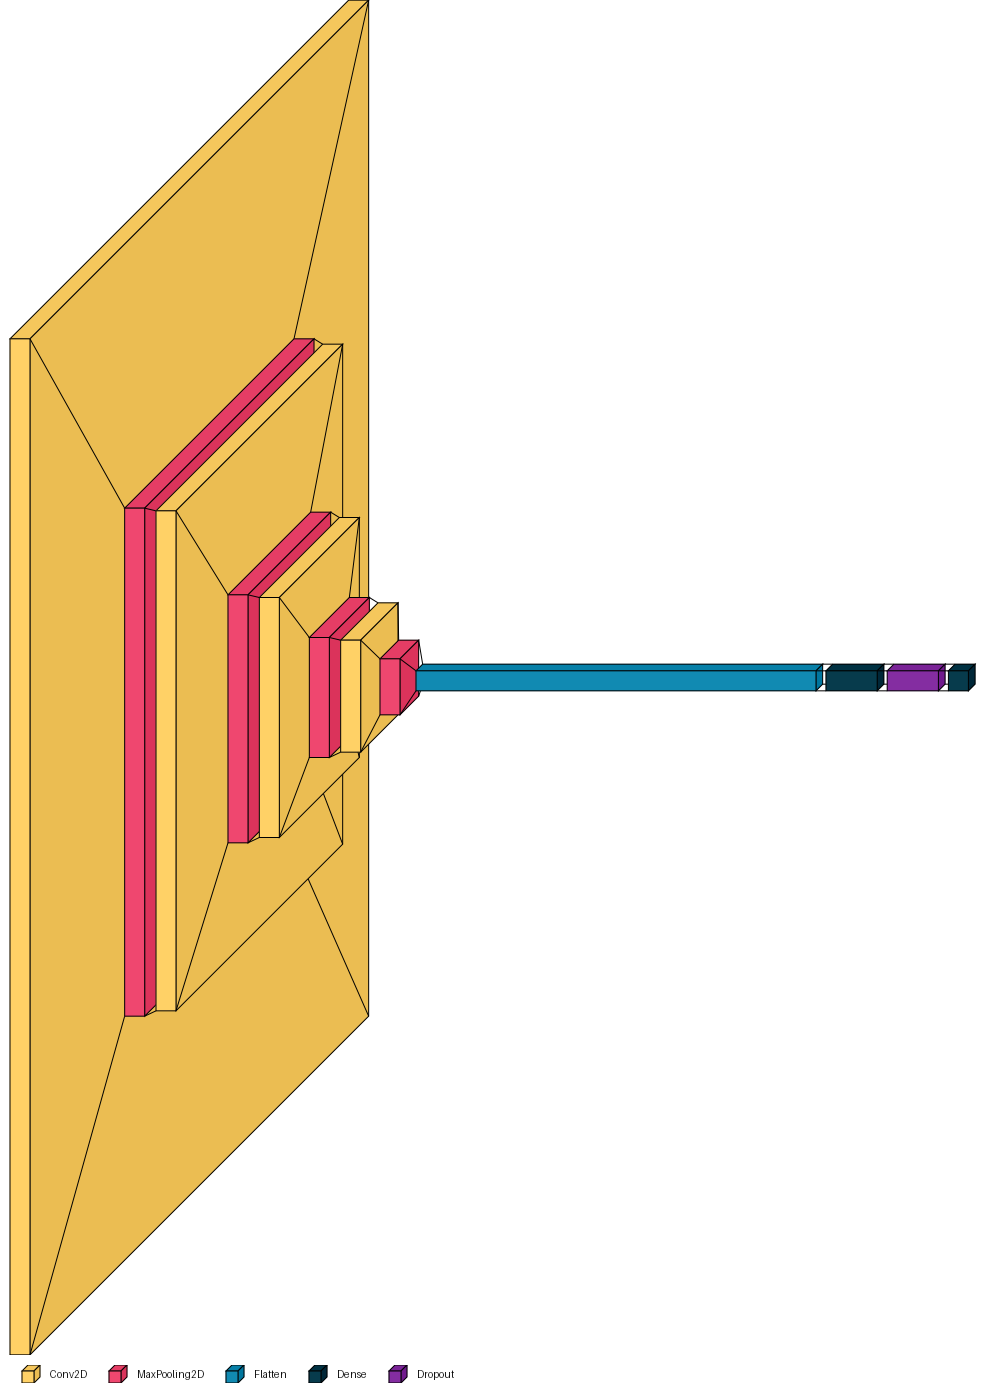


Visualizing: Dropout2



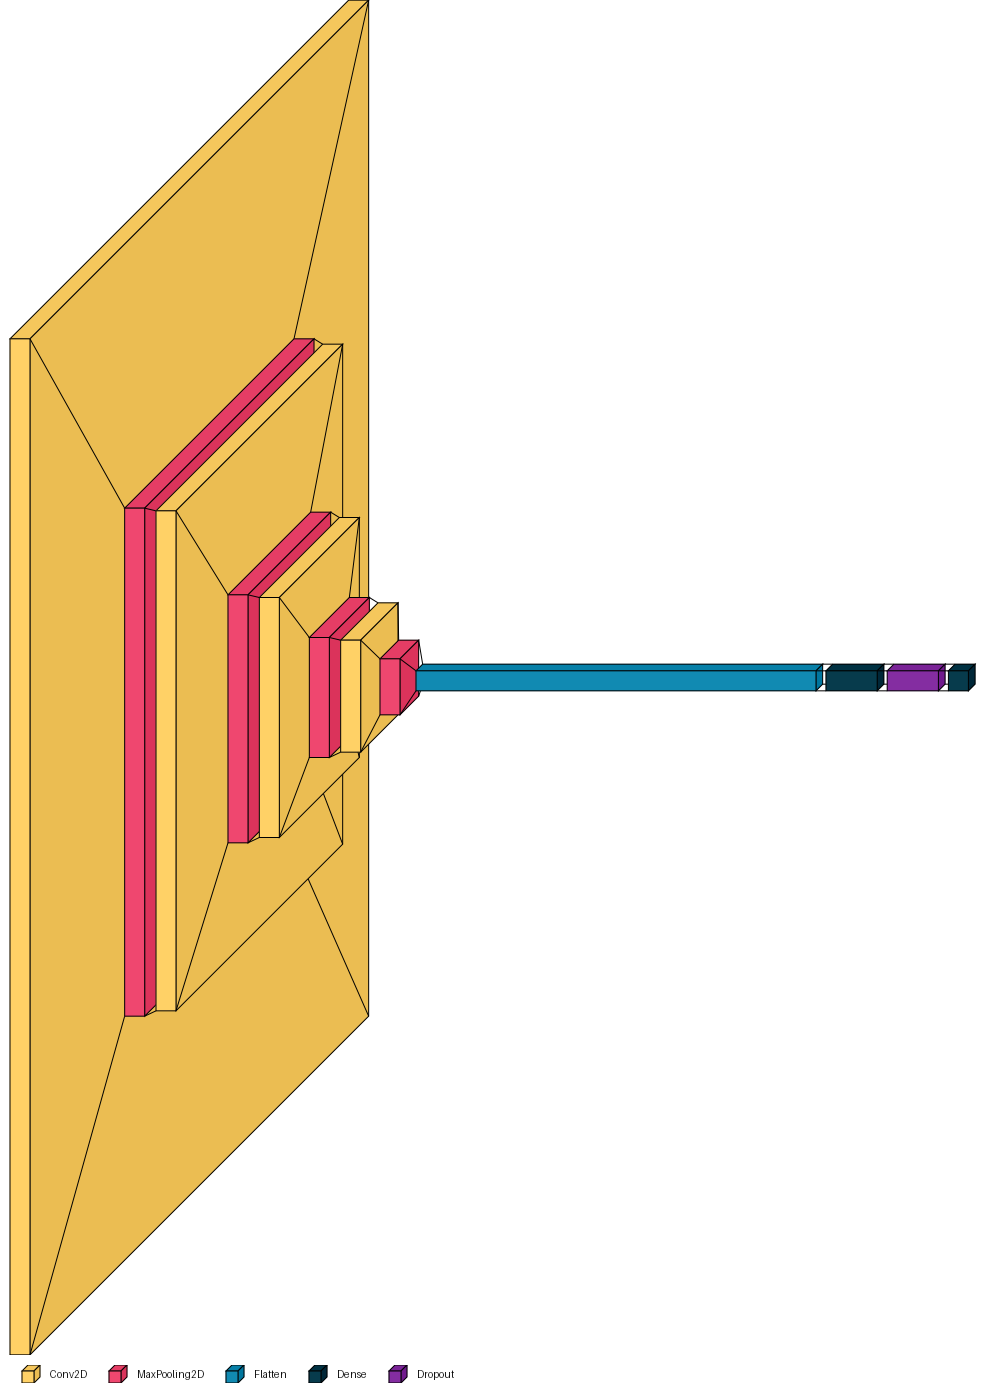


Visualizing: Dropout3



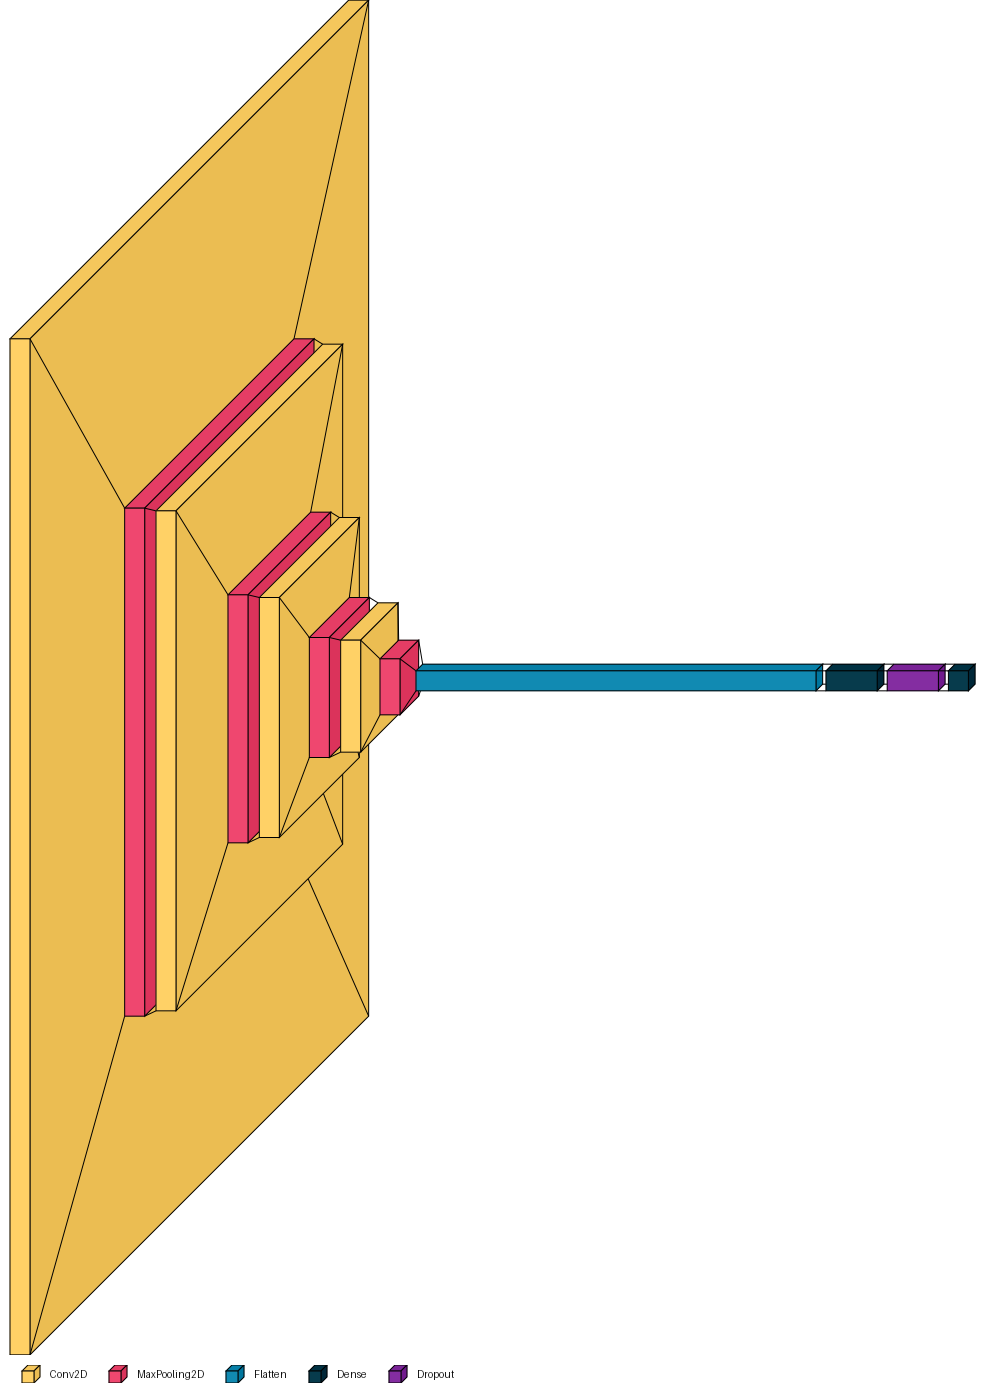


Visualizing: Dropout5



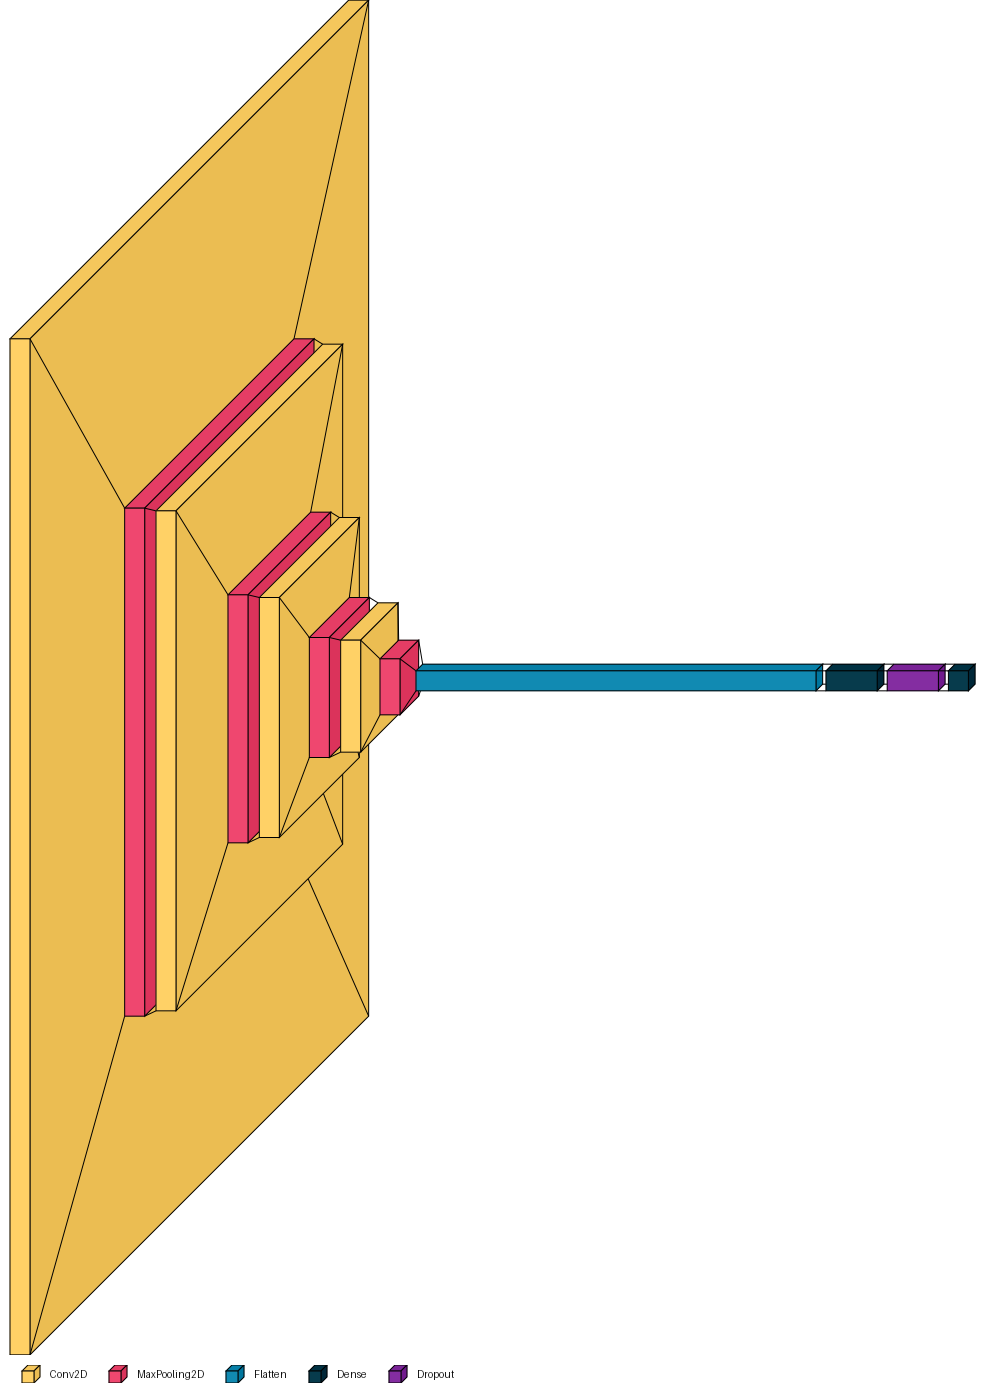


Visualizing: Data Augmentation



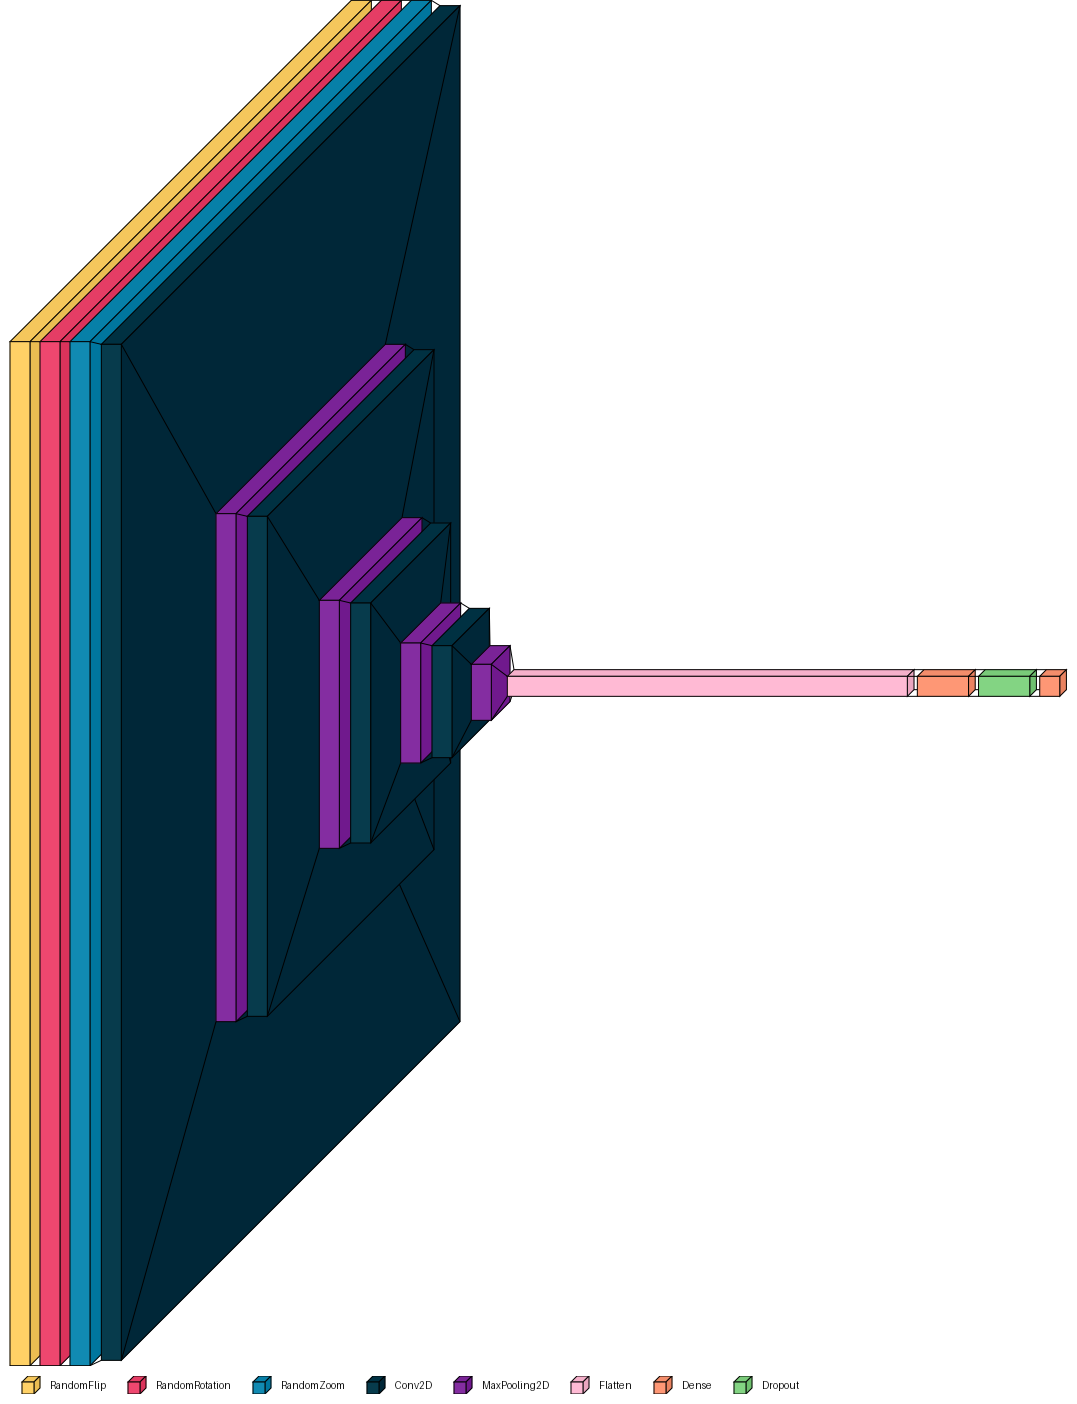

In [20]:
from IPython.display import display
import visualkeras
def visualize_model_structure(model):
    img = visualkeras.layered_view(model, legend=True)
    display(img)

# Visualize all models in notebook
def visualize_all_models(models_info):
    for name, model in models_info.items():
        print(f"\nVisualizing: {name}\n")
        visualize_model_structure(model)

# Example usage
visualize_all_models(models_info)